## Импорты библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm

from sqlalchemy import create_engine, Column, Integer, String, TIMESTAMP, ARRAY
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings('ignore')

import json
pd.set_option("display.max_columns", None)

## Константы

In [2]:
PAIRS_NAME = ['bnb_btc', 'eth_btc', 'bnb_eth','btc_usdt', 'eth_usdt', 'bnb_usdt']
LABELS_NAME = [
    'label',
    'bnb_btc_min',
    'bnb_btc_max',
    'bnb_btc_min_max',
    'eth_btc_min',
    'eth_btc_max',
    'eth_btc_min_max',
    'bnb_eth_min',
    'bnb_eth_max',
    'bnb_eth_min_max',
    'not_buy']


## Чтение данных

In [4]:
def config(service):
    with open('develop/config_connect.json', 'r') as f:
        config = json.load(f)
    if service == 'binance':
        config = config['binance']
    if service == 'postgres':
        config = config['postgres']

    return config

config_bin_dev = config('postgres')['binance']
engine = create_engine(f"postgresql+psycopg2://"
                       f"{config_bin_dev['user_name']}:"
                       f"{config_bin_dev['password']}@"
                       f"{config_bin_dev['server']}/"
                       f"{config_bin_dev['base_name']}")

In [3]:


ticker_price = pd.read_sql_table(table_name='ticker_price',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=PAIRS_NAME)
ticker_price = ticker_price.astype('float')

labels = pd.read_sql_table(table_name='labels',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=LABELS_NAME)

ticker = pd.read_sql_table(table_name='ticker',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=['time_server'])

btc_usdt_24hr = pd.read_sql_table(table_name='btc_usdt_24hr',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=['volume']).rename(columns={"volume": "volume_btc_usdt"})
btc_usdt_24hr = btc_usdt_24hr.astype('float')

eth_usdt_24hr = pd.read_sql_table(table_name='eth_usdt_24hr',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=['volume']).rename(columns={"volume": "volume_eth_usdt"})
eth_usdt_24hr = eth_usdt_24hr.astype('float')

eth_btc_24hr = pd.read_sql_table(table_name='eth_btc_24hr',
                                    con=engine,
                                    schema='public',
                                    index_col='id_ticker',
                                    columns=['volume']).rename(columns={"volume": "volume_eth_btc"})
eth_btc_24hr = eth_btc_24hr.astype('float')



In [4]:
display(ticker_price)
display(labels)
display(ticker)
display(btc_usdt_24hr)

,bnb_btc,eth_btc,bnb_eth,btc_usdt,eth_usdt,bnb_usdt
id_ticker,,,,,,
1,0.013989,0.075078,0.1863,20696.19,1553.98,289.5
2,0.013989,0.075082,0.1863,20697.38,1554.03,289.5
3,0.013989,0.075082,0.1862,20695.74,1554.03,289.4
4,0.013988,0.075082,0.1862,20696.33,1553.78,289.4
5,0.013987,0.075075,0.1862,20698.32,1553.82,289.5
...,...,...,...,...,...,...
940226,0.015624,0.077199,0.2025,18149.65,1400.94,283.6
940227,0.015623,0.077217,0.2025,18149.53,1400.95,283.6
940228,0.015624,0.077210,0.2025,18148.63,1401.43,283.5


,label,bnb_btc_min,bnb_btc_max,bnb_btc_min_max,eth_btc_min,eth_btc_max,eth_btc_min_max,bnb_eth_min,bnb_eth_max,bnb_eth_min_max,not_buy
id_ticker,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
782764,0,0,0,0,0,0,0,0,0,0,1
782765,0,0,0,0,0,0,0,0,0,0,1
782766,0,0,0,0,0,0,0,0,0,0,1


,time_server
id_ticker,
1,2022-10-26 21:59:39.307
2,2022-10-26 21:59:45.806
3,2022-10-26 21:59:51.300
4,2022-10-26 21:59:56.782
5,2022-10-26 22:00:03.013
...,...
940227,2023-01-12 12:28:39.482
940228,2023-01-12 12:28:45.034
940229,2023-01-12 12:28:50.589


,volume_btc_usdt
id_ticker,
55681,198592.43478
55682,198560.42057
55683,198551.76616
55684,198529.87566
55685,198498.26877
...,...
940227,319937.07812
940228,319962.18510
940229,320002.64863


In [5]:
# data = pd.concat((ticker,
#                   ticker_price,
#                   btc_usdt_24hr,
#                   eth_usdt_24hr,
#                   eth_btc_24hr,
#                   labels), axis=1)

data = pd.concat((ticker,
                  ticker_price), axis=1)

In [6]:
data

,time_server,bnb_btc,eth_btc,bnb_eth,btc_usdt,eth_usdt,bnb_usdt
id_ticker,,,,,,,
1,2022-10-26 21:59:39.307,0.013989,0.075078,0.1863,20696.19,1553.98,289.5
2,2022-10-26 21:59:45.806,0.013989,0.075082,0.1863,20697.38,1554.03,289.5
3,2022-10-26 21:59:51.300,0.013989,0.075082,0.1862,20695.74,1554.03,289.4
4,2022-10-26 21:59:56.782,0.013988,0.075082,0.1862,20696.33,1553.78,289.4
5,2022-10-26 22:00:03.013,0.013987,0.075075,0.1862,20698.32,1553.82,289.5
...,...,...,...,...,...,...,...
940227,2023-01-12 12:28:39.482,0.015623,0.077217,0.2025,18149.53,1400.95,283.6
940228,2023-01-12 12:28:45.034,0.015624,0.077210,0.2025,18148.63,1401.43,283.5
940229,2023-01-12 12:28:50.589,0.015624,0.077210,0.2025,18150.12,1401.43,283.6


## Анализ данных

### Внешний вид графиков

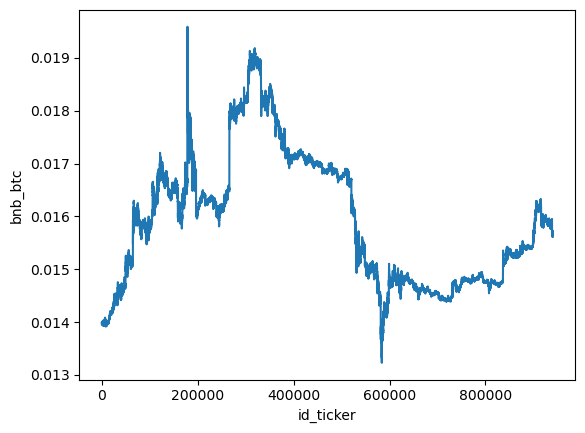

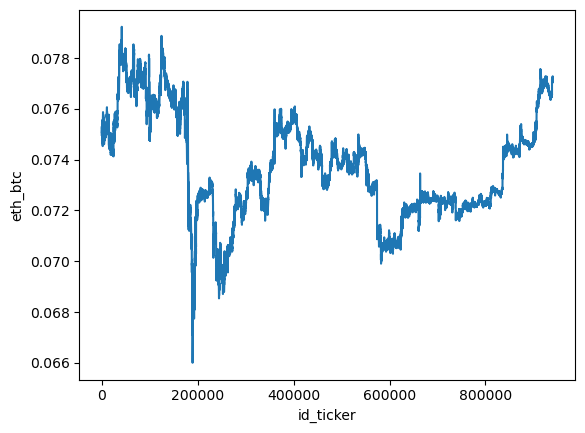

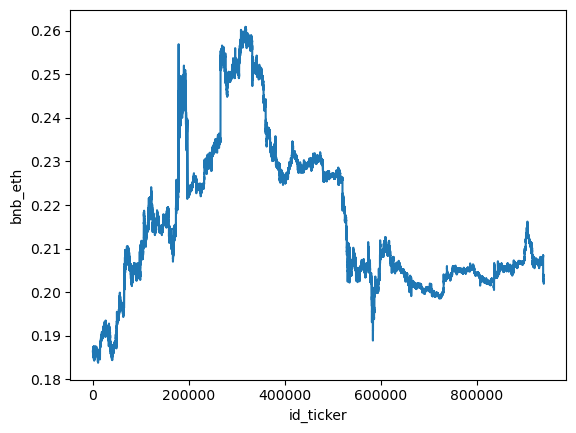

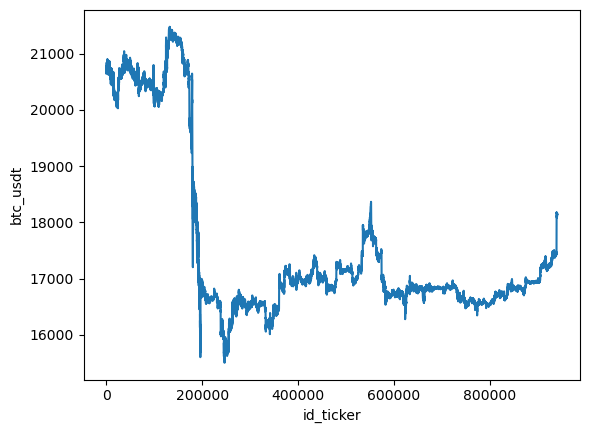

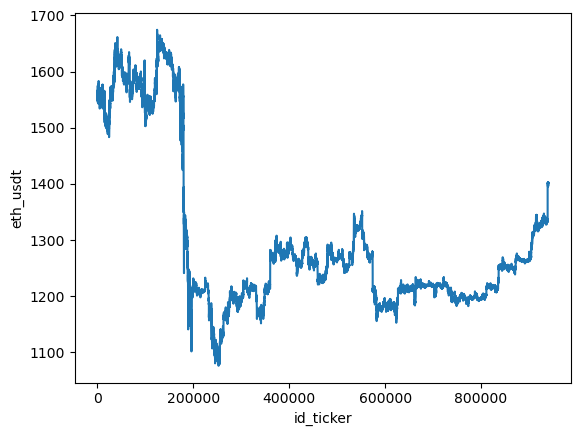

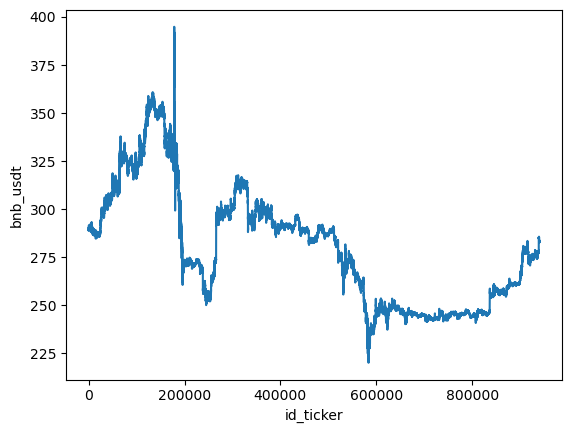

ValueError: Could not interpret value `volume_btc_usdt` for parameter `y`

In [7]:
sns.lineplot(data=data, x='id_ticker', y='bnb_btc')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='eth_btc')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='bnb_eth')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='btc_usdt')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='eth_usdt')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='bnb_usdt')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='volume_btc_usdt')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='volume_eth_usdt')
plt.show()
sns.lineplot(data=data, x='id_ticker', y='volume_eth_btc')
plt.show()

### Проверка labels

#### Распределение

In [ ]:
doli = data[['bnb_btc_min',
             'bnb_btc_max',
             'eth_btc_min',
             'eth_btc_max',
             'bnb_eth_min',
             'bnb_eth_max',
             'not_buy']].sum() * 100 / data.shape[0]

print(f"{doli}")

#### Наложение

In [ ]:
sns.lineplot(data=data[90_000:99_000], x='id_ticker', y='bnb_btc', hue="bnb_btc_min_max", palette='bright')
plt.show()
sns.lineplot(data=data[90_000:99_000], x='id_ticker', y='eth_btc', hue="eth_btc_min_max", palette='bright')
plt.show()
sns.lineplot(data=data[90_000:99_000], x='id_ticker', y='bnb_eth', hue="bnb_eth_min_max", palette='bright')
plt.show()

### Проверка разрывов временного ряда

#### Количество разрывов относительно их продолжительности

In [ ]:
gap = list()
for gap_seconds in range(100):
    gap.append((ticker['time_server']-ticker['time_server'].shift(1) > pd.Timedelta(seconds=gap_seconds)).sum())
gap = pd.DataFrame(gap, columns=['gap_count'])

In [ ]:
sns.lineplot(data=gap[14:])

#### Локализация разрывов на временном ряду

In [ ]:
gap_seconds = 20 # длительность разыва в секундах
ticker['gap'] = ticker['time_server']-ticker['time_server'].shift(1) > pd.Timedelta(seconds=gap_seconds)
ticker['timedelta'] = ticker['time_server']-ticker['time_server'].shift(1)

In [ ]:
sns.scatterplot(data=ticker, x="time_server", y="gap")

## Сезонность и тренды

In [ ]:
data = data.set_index('time_server')

In [ ]:
data['bnb_btc'][:-1]

## Час и день недели

## Торги (Trade)

In [332]:
time = pd.read_sql_table(table_name='trade',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['local_time'])
time = time.sort_index()

trade_symbol = pd.read_sql_table(table_name='trade',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['orderSymbol'])
trade_symbol = trade_symbol.sort_index()

trade = pd.read_sql_table(table_name='trade',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['period_time','predict','part','volume_before',
                                             'volume_btc','volume_eth','volume_bnb','profit_usdt',
                                             'fee_usdt','bnb_btc','eth_btc','bnb_eth','btc_usdt',
                                             'eth_usdt','bnb_usdt', 'profit_fee_status',
                                             'orderCommission'])
trade = trade.astype('float')
trade = trade.sort_index()

trade = pd.concat((time, trade,trade_symbol), axis = 1).set_index('local_time')

### Профит

Прибыль за последние N тиков.

In [333]:
#time_start = '2023-01-14 17:10:00' # profit_fee_coef = 0.1
#time_start = '2023-01-14 08:46:00' # profit_fee_coef = 0.5
#time_start = '2023-01-16 11:31:00' # profit_fee_coef = 0.5 (покупка крипты за usdt)
#time_start = '2023-01-17 08:01:00' # profit_fee_coef = 1
time_start = '2023-01-17 22:15:00' # profit_fee_coef = 1 (лимитный ордер, отменён, большая просадка на графике)

#time_end = '2023-01-17 08:00:00'

In [334]:
trade = trade[time_start:]

In [335]:
trade['volume_not_trade'] = (trade['volume_btc'][0]*trade['btc_usdt'] +
                             trade['volume_eth'][0]*trade['eth_usdt'] +
                             trade['volume_bnb'][0]*trade['bnb_usdt'])

In [336]:
trade['profit'] = (trade['volume_before'] - trade['volume_not_trade'])

In [337]:
print(f'Прибыль: {trade["profit"][-1]}')
print(f'Комиссия: {(trade["orderCommission"]*trade["bnb_usdt"]).sum()}')

Прибыль: -0.9382118715000161
Комиссия: 0.219227099


In [338]:
trade['volume_btc_usdt'] = trade['volume_btc']*trade['btc_usdt']
trade['volume_eth_usdt'] = trade['volume_eth']*trade['eth_usdt']
trade['volume_bnb_usdt'] = trade['volume_bnb']*trade['bnb_usdt']

### Медиана периода Trade

In [339]:
period_median = trade['period_time'].median()
print(f'Медианное значение периода: {period_median}')

Медианное значение периода: 6.101951360702515


### Число сделок

In [340]:
trade['trade'] = (trade['orderSymbol'] != 'None').astype('int')
trade['trade_on_volume'] = trade['trade']*trade['volume_before']
print(f'Число сделок: {trade["trade"].sum()}')

Число сделок: 13


### Графики

#### Объёмы и профит

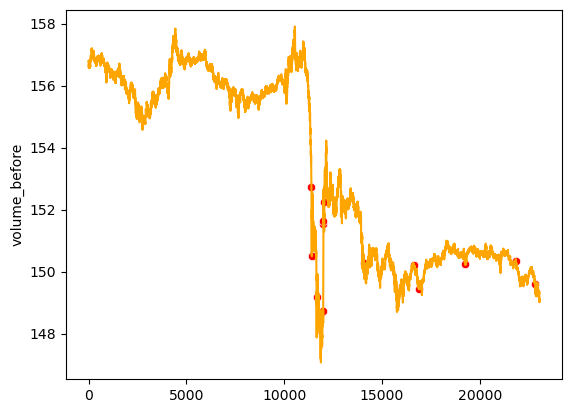

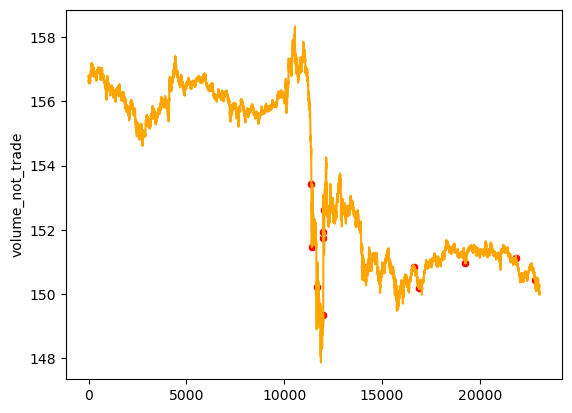

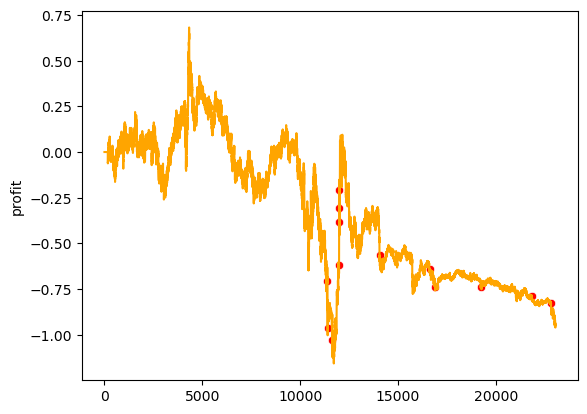

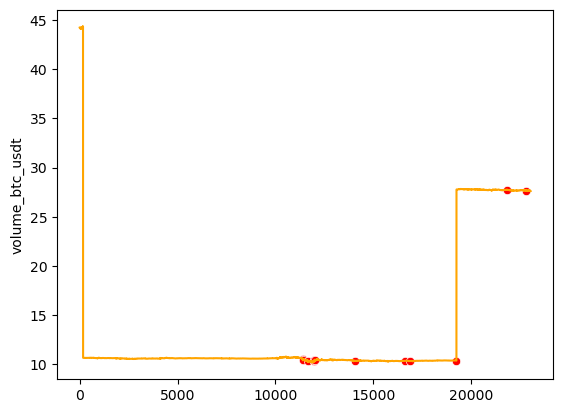

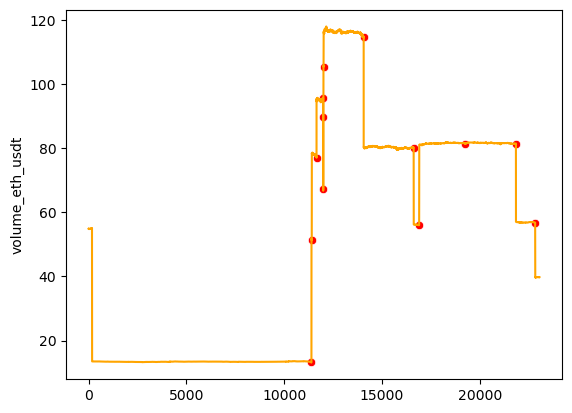

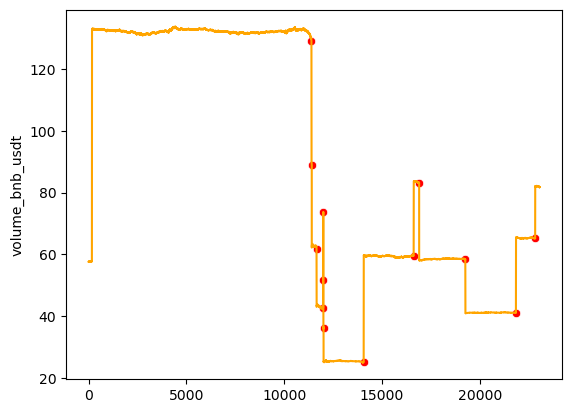

In [341]:
for y in ['volume_before', 'volume_not_trade', 'profit', 'volume_btc_usdt', 'volume_eth_usdt', 'volume_bnb_usdt']:
    sns.lineplot(data=trade, x=range(trade.shape[0]), y=y, color='orange')
    y = trade['trade']*trade[y]
    y[y == 0] = np.nan
    sns.scatterplot(data=trade, x=range(trade.shape[0]), y=y, color='red')
    plt.show()

#### Сделки на тренде

In [342]:
x_len = trade.shape[0]

------------------------------------------------
bnb_btc


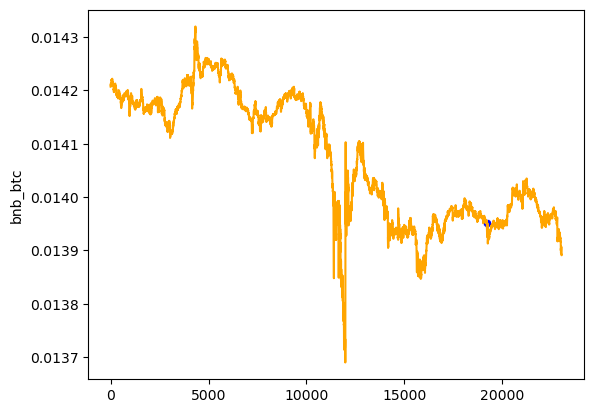

------------------------------------------------
eth_btc


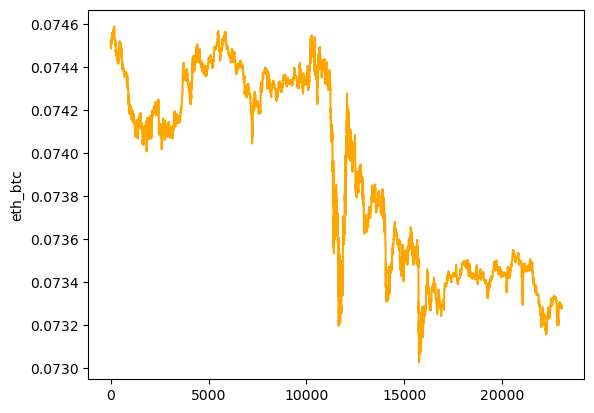

------------------------------------------------
bnb_eth


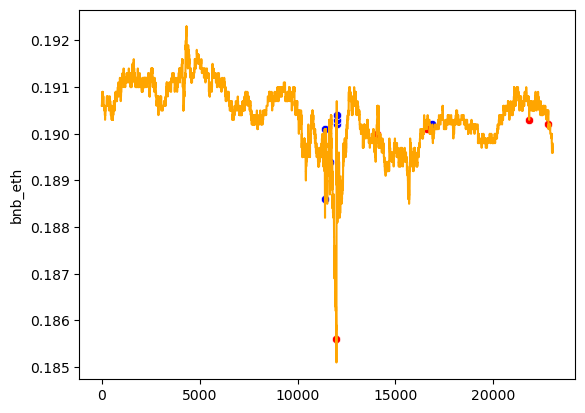

In [343]:
for i, pair in enumerate(['bnb_btc','eth_btc','bnb_eth']):
    
    trade[pair+'_min'] = trade['trade']*trade[pair]*(trade['predict'] == (i+1)*2-1) # заменить 0 на nan
    trade[pair+'_min'].replace(0, np.nan, inplace=True)
    trade[pair+'_max'] = trade['trade']*trade[pair]*(trade['predict'] == (i+1)*2) # заменить 0 на nan
    trade[pair+'_max'].replace(0, np.nan, inplace=True)
            
    fig, ax = plt.subplots()
    print('------------------------------------------------')
    print(pair)
    sns.lineplot(data=trade[:x_len], x=range(x_len), y=pair, ax=ax, color='orange')
    sns.scatterplot(data=trade[:x_len], x=range(x_len), y=pair+'_max', ax=ax, color='blue')
    sns.scatterplot(data=trade[:x_len], x=range(x_len), y=pair+'_min', ax=ax, color='red')
    
    #ax.plot(range(x_len),trade[pair], color='orange')
    plt.show()

## Торги BTC_USDT

In [553]:
time = pd.read_sql_table(table_name='trade_btcusdt',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['local_time'])
time = time.sort_index()

trade_symbol = pd.read_sql_table(table_name='trade_btcusdt',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['orderSymbol'])
trade_symbol = trade_symbol.sort_index()

trade = pd.read_sql_table(table_name='trade_btcusdt',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['period_time','predict','part','volume_before',
                                             'volume_btc','volume_usdt',
                                             'fee_usdt','bnb_btc','eth_btc','bnb_eth','btc_usdt',
                                             'eth_usdt','bnb_usdt', 'profit_fee_status',
                                             'orderCommission'])
trade = trade.astype('float')
trade = trade.sort_index()

trade = pd.concat((time, trade,trade_symbol), axis = 1).set_index('local_time')

In [554]:
time_start = '2023-01-23 18:25:00' # profit_fee_coef = 1 (лимитный ордер, отменён, большая просадка на графике)
#time_end = '2023-01-17 08:00:00'

trade = trade[time_start:]

### Профит

In [555]:
trade['volume_not_trade'] = (trade['volume_btc'][0]*trade['btc_usdt'] +
                             trade['volume_usdt'][0])
trade['profit'] = (trade['volume_before'] - trade['volume_not_trade'])
trade['volume_btc_usdt'] = trade['volume_btc']*trade['btc_usdt']

In [556]:
print(f'Прибыль: {trade["profit"][-1]}')
print(f'Комиссия: {(trade["orderCommission"]*trade["bnb_usdt"]).sum()}')

Прибыль: 0.7699873000000252
Комиссия: 0.0


### Медиана периода Trade

In [557]:
period_median = trade['period_time'].median()
print(f'Медианное значение периода: {period_median:.2f}')

Медианное значение периода: 5.56


### Число сделок

In [558]:
trade['trade'] = (trade['orderSymbol'] != 'None').astype('int')
trade['trade_on_volume'] = trade['trade']*trade['volume_before']
print(f'Число сделок: {trade["trade"].sum()}')

Число сделок: 15


### Графики

#### Объёмы и профит

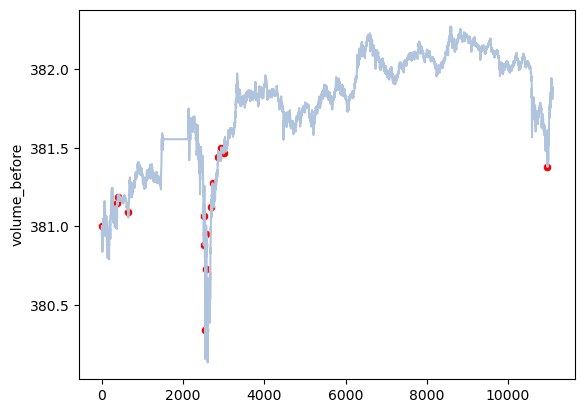

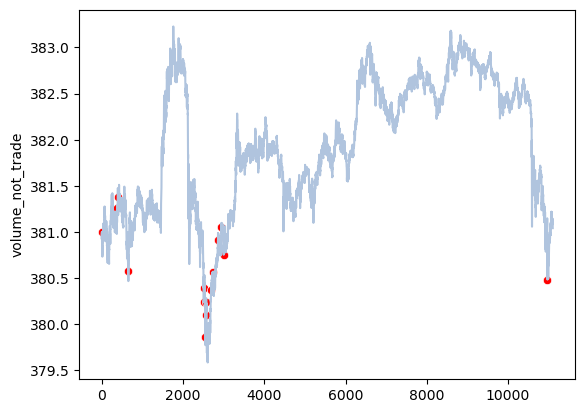

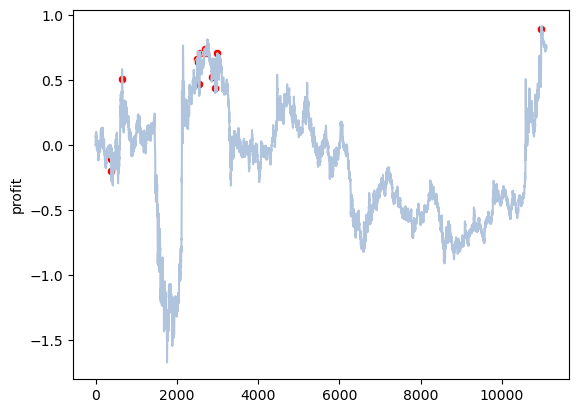

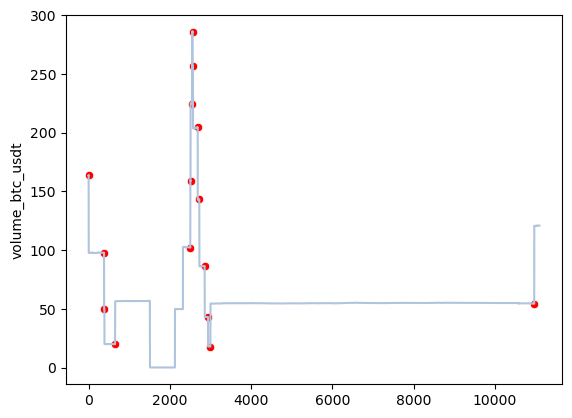

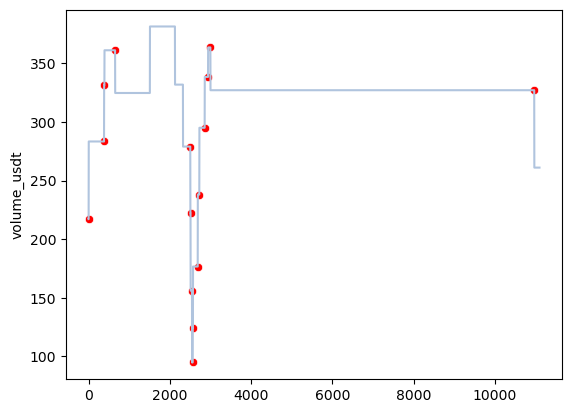

In [559]:
for y in ['volume_before', 'volume_not_trade', 'profit', 'volume_btc_usdt', 'volume_usdt']:
    sns.lineplot(data=trade, x=range(trade.shape[0]), y=y, color='lightsteelblue')
    y = trade['trade']*trade[y]
    y[y == 0] = np.nan
    sns.scatterplot(data=trade, x=range(trade.shape[0]), y=y, color='red')
    plt.show()

#### Сделки на тренде

------------------------------------------------
btc_usdt


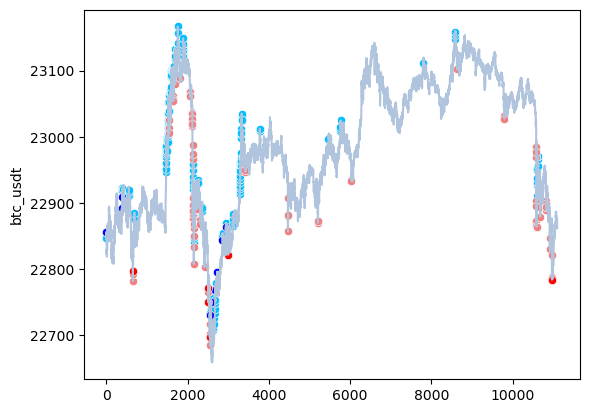

In [560]:
x_len = trade.shape[0]

for i, pair in enumerate(['btc_usdt']):
    
    # наложение predict
    trade[pair+'_predict_min'] = trade[pair]*(trade['predict'] == (i+1)*2-1) # заменить 0 на nan
    trade[pair+'_predict_max'] = trade[pair]*(trade['predict'] == (i+1)*2) # заменить 0 на nan
    trade[pair+'_predict_min'].replace(0, np.nan, inplace=True)
    trade[pair+'_predict_max'].replace(0, np.nan, inplace=True)
    
    # наложение сделок
    trade[pair+'_trade_min'] = trade['trade']*trade[pair]*(trade['predict'] == (i+1)*2-1) # заменить 0 на nan
    trade[pair+'_trade_max'] = trade['trade']*trade[pair]*(trade['predict'] == (i+1)*2) # заменить 0 на nan
    trade[pair+'_trade_min'].replace(0, np.nan, inplace=True)
    trade[pair+'_trade_max'].replace(0, np.nan, inplace=True)
            
    fig, ax = plt.subplots()
    print('------------------------------------------------')
    print(pair)
    sns.lineplot(data=trade[:x_len], x=range(x_len), y=pair, ax=ax, color='lightsteelblue')
    sns.scatterplot(data=trade[:x_len], x=range(x_len), y=pair+'_predict_max', ax=ax, color='deepskyblue')
    sns.scatterplot(data=trade[:x_len], x=range(x_len), y=pair+'_predict_min', ax=ax, color='lightcoral')
    sns.scatterplot(data=trade[:x_len], x=range(x_len), y=pair+'_trade_max', ax=ax, color='blue')
    sns.scatterplot(data=trade[:x_len], x=range(x_len), y=pair+'_trade_min', ax=ax, color='red')
    
    #ax.plot(range(x_len),trade[pair], color='orange')
    plt.show()